## Libraries 

In [25]:
import pandas as pd
import numpy as np
import re

# API
import youtube_api_key
import genius_api_key
from googleapiclient.discovery import build
from lyricsgenius import Genius
from IPython.display import JSON

# Web scraping
from selenium import  webdriver
from  webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By

# Visualization
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)
import matplotlib.pyplot as plt
plt.rc('font', family='Apple SD Gothic Neo')
import matplotlib.ticker as ticker
import plotly.express as px
from plotly.subplots import make_subplots

# NLP task
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

## Information retrieval using YouTube Data API v3

In [26]:
# Import your YouTube API key
api_key = youtube_api_key.api_key
api_service_name = "youtube"
api_version = "v3"

In [27]:
# Get credentials and create an API client
youtube = build(api_service_name, api_version, developerKey=api_key)

In [28]:
# KQ ENTERTAINMENT channel id
channel_id = ['UCQdq-lqPEq_yZ_wP_kuVB9Q']

In [29]:
def get_stats(youtube, channel_id):
    
    # Get channel playlist id
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=channel_id
    )
    response = request.execute()
    
    for item in response['items']:
        playlistId = item['contentDetails']['relatedPlaylists']['uploads']
    
    # Get channel videos ids
    video_ids = []
    
    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=playlistId, 
        maxResults = 50
    )
    response = request.execute()
    
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
    
    next_page_token = response.get('nextPageToken')
    
    while next_page_token is not None:
        request = youtube.playlistItems().list(
            part="contentDetails",
            playlistId=playlistId, 
            maxResults = 50,
            pageToken = next_page_token
        )
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response.get('nextPageToken')
    
    # Get videos stats
    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute()

        for video in response['items']:
            stats_to_keep = {'snippet':['title', 'description', 'publishedAt'],
                            'statistics':['viewCount', 'likeCount', 'commentCount']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                         video_info[v] = None
            all_video_info.append(video_info)
            
    return pd.DataFrame(all_video_info)
    

In [30]:
df = get_stats(youtube, channel_id)

In [31]:
df.head()

,video_id,title,description,publishedAt,viewCount,likeCount,commentCount
0,AXcN2NVXQ_A,🐶🥁😼 #Shorts,🐶🥁😼 #Shorts\n\n\n▶ KQ Fellaz 2 Official TikTok...,2023-02-20T10:00:03Z,5205,1224,36
1,gfV94z0jXNA,I WANNA ❤ U #Shorts,I WANNA ❤ U #Shorts\n\n\n▶ KQ Fellaz 2 Officia...,2023-02-18T13:00:01Z,9171,2340,32
2,1-hlvjroSzY,이상하고 아름다운 도깨비집 챌린지😈,이상하고 아름다운 도깨비집 챌린지😈\n\n\n▶ KQ Fellaz 2 Officia...,2023-02-17T14:08:17Z,12790,2276,23
3,6_OVzXf35k0,인생은 Roller coaster🎢 #Shorts,인생은 Roller coaster🎢 #Shorts\n\n\n▶ KQ Fellaz 2...,2023-02-17T13:00:01Z,5959,1634,25
4,1Yr-x6vY2WE,왼손은 거들 뿐❗🏀 #Shorts,왼손은 거들 뿐❗🏀 #Shorts\n\n\n▶ KQ Fellaz 2 Official...,2023-02-16T10:00:02Z,7023,1598,33


### Data pre-processing

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 616 entries, 0 to 615
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   video_id      616 non-null    object
 1   title         616 non-null    object
 2   description   616 non-null    object
 3   publishedAt   616 non-null    object
 4   viewCount     616 non-null    object
 5   likeCount     616 non-null    object
 6   commentCount  616 non-null    object
dtypes: object(7)
memory usage: 33.8+ KB


In [33]:
int_cols = ['viewCount', 'likeCount', 'commentCount']
df[int_cols] = df[int_cols].astype('int')
df['publishedAt'] = df['publishedAt'].astype('datetime64[ns]')

In [34]:
df.dtypes

video_id                object
title                   object
description             object
publishedAt     datetime64[ns]
viewCount                int64
likeCount                int64
commentCount             int64
dtype: object

### EDA

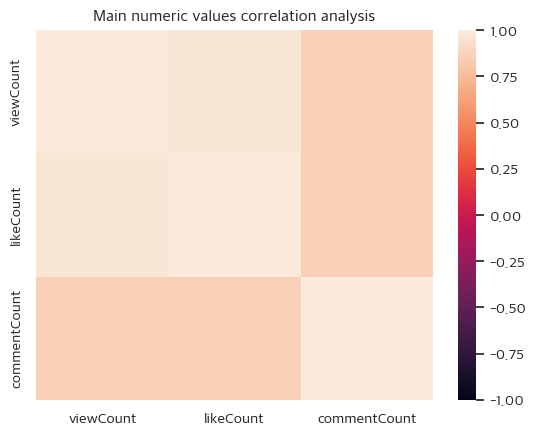

In [35]:
plt.rc('axes', unicode_minus=False)
sns.heatmap(df[['viewCount', 'likeCount','commentCount']].corr(), vmin=-1, vmax=1)
plt.title('Main numeric values correlation analysis')
plt.show()

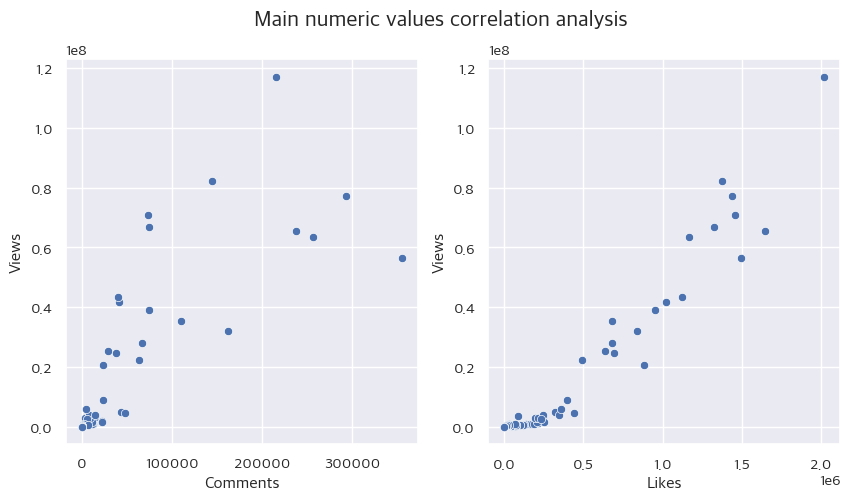

In [36]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))
ax = sns.scatterplot(data=df, x='commentCount', y='viewCount', ax=axs[0])
ax.set_xlabel('Comments')
ax.set_ylabel('Views')
ax = sns.scatterplot(data=df, x='likeCount', y='viewCount', ax=axs[1])
ax.set_xlabel('Likes')
ax.set_ylabel('Views')
fig.suptitle('Main numeric values correlation analysis', fontsize=16)
plt.show()

In [37]:
# Create another attribute to distinguish group videos
df['name'] = 'KQ'
df.loc[df['title'].str.contains(r'ATEEZ', case=False), 'name'] = 'ATEEZ'

In [38]:
grouped = df.groupby('name').agg(
    Number=('video_id','count'),
    Views=('viewCount', 'sum'),
    likes=('likeCount', 'sum'),
    Comments=('commentCount', 'sum')
)
grouped

,Number,Views,likes,Comments
name,,,,
ATEEZ,115,988896154,28620657,2784910
KQ,501,28341701,2918675,136566


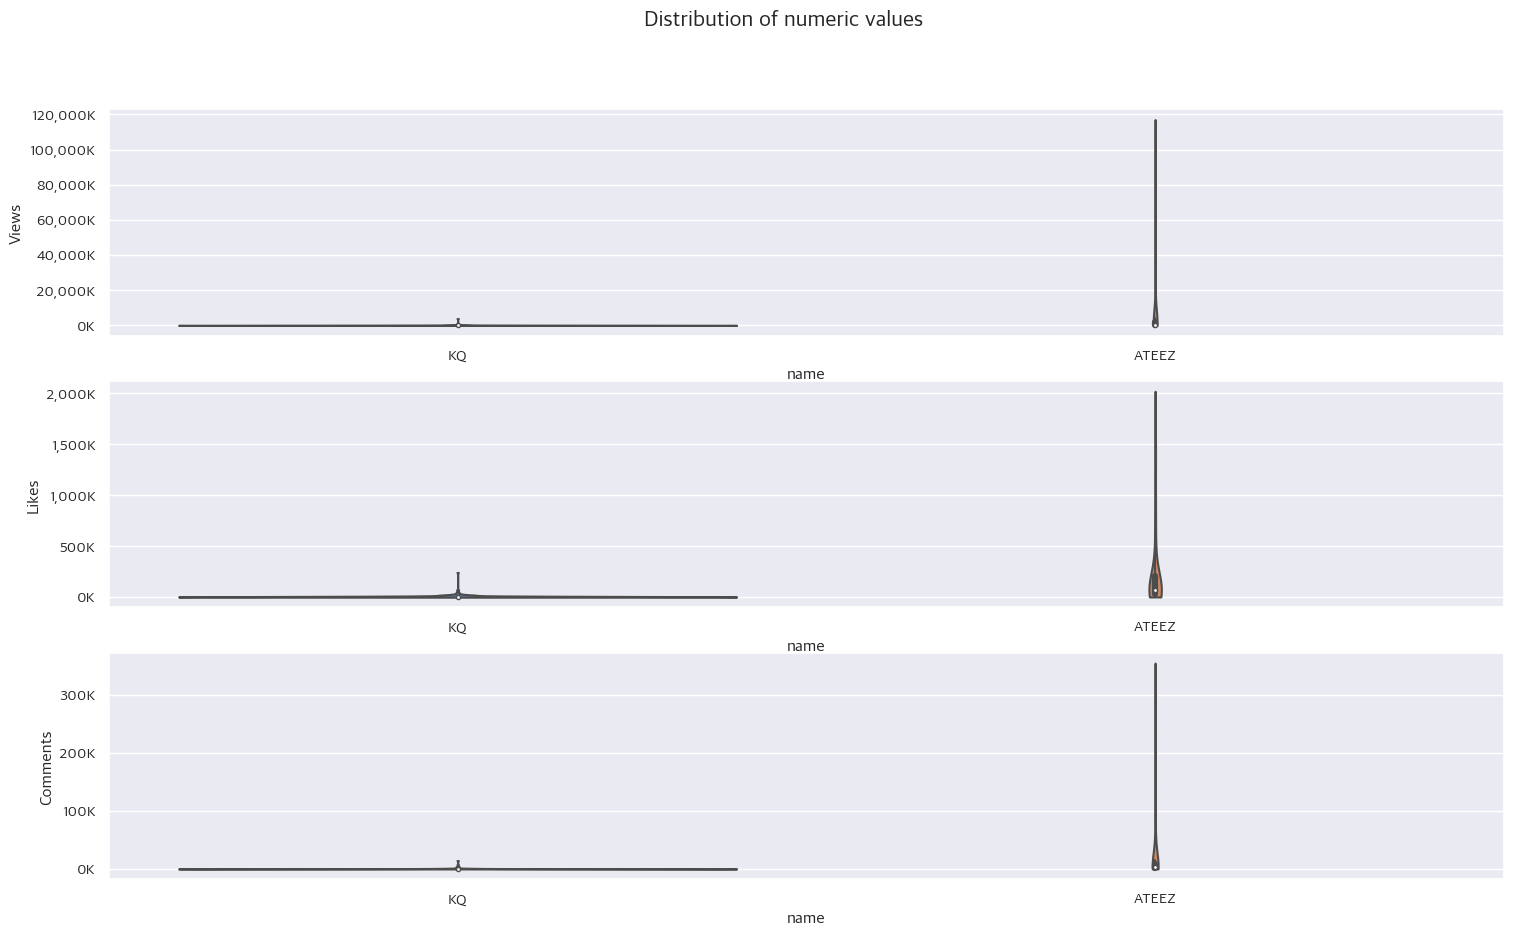

In [39]:
fig, axs = plt.subplots(3,1, figsize=(18,10))
ax = sns.violinplot(x='name', y='viewCount', data=df, ax=axs[0], cut=0)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x,pos:'{:,.0f}'.format(x/1000) + 'K'))
ax.set_ylabel("Views")
ax = sns.violinplot(x='name', y='likeCount', data=df, ax=axs[1], cut=0)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x,pos:'{:,.0f}'.format(x/1000) + 'K'))
ax.set_ylabel("Likes")
ax = sns.violinplot(x='name', y='commentCount', data=df, ax=axs[2], cut=0)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x,pos:'{:,.0f}'.format(x/1000) + 'K'))
ax.set_ylabel("Comments")
fig.suptitle('Distribution of numeric values', fontsize=16)
plt.show()

In [40]:
# Switch focus on ATEEZ
ateez = df[df['name'] == 'ATEEZ']

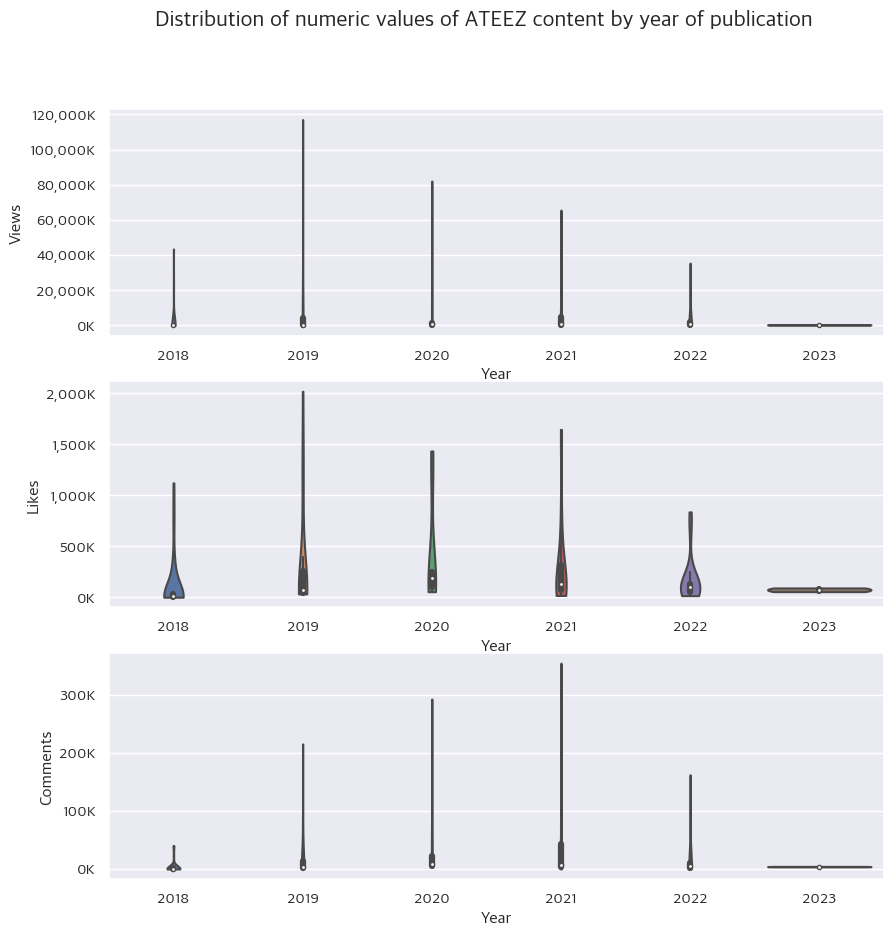

In [41]:
fig, axs = plt.subplots(3,1, figsize=(10,10))
ax = sns.violinplot(x=ateez['publishedAt'].dt.year, y='viewCount', data=ateez, ax=axs[0], cut=0)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x,pos:'{:,.0f}'.format(x/1000) + 'K'))
ax.set_ylabel("Views")
ax.set_xlabel("Year")
ax = sns.violinplot(x=ateez['publishedAt'].dt.year, y='likeCount', data=ateez, ax=axs[1], cut=0)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x,pos:'{:,.0f}'.format(x/1000) + 'K'))
ax.set_ylabel("Likes")
ax.set_xlabel("Year")
ax = sns.violinplot(x=ateez['publishedAt'].dt.year, y='commentCount', data=ateez, ax=axs[2], cut=0)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x,pos:'{:,.0f}'.format(x/1000) + 'K'))
ax.set_ylabel("Comments")
ax.set_xlabel("Year")
fig.suptitle('Distribution of numeric values of ATEEZ content by year of publication', fontsize=16)
plt.show()

## Lyrics information retrieval

In [42]:
# Import your Genius API key
token = genius_api_key.api_key

In [43]:
def only_mv(df):
    
    df = df.copy()
    df = df[df['title'].str.contains('Official MV', case=False)]
    df = df.drop(df[df['title'].str.contains('Teaser|MV Clip', case=False)].index).reset_index(drop=True)
    df['song'] = df['title'].apply(lambda x: re.split(r" - | Official", x)[1])
    df['song'] = df['song'].apply(lambda x: x[1:-1])
    df['date'] = df['publishedAt'].dt.date.astype('datetime64[ns]')
    
    return df

In [44]:
mv_df = only_mv(ateez)

In [45]:
mv_df.head()

,video_id,title,description,publishedAt,viewCount,likeCount,commentCount,name,song,date
0,SszP3hlQ55Y,ATEEZ(에이티즈) - 'HALAZIA' Official MV,[SPIN OFF : FROM THE WITNESS]\nRelease Date: 2...,2022-12-30 05:00:02,35424533,680841,109812,ATEEZ,HALAZIA,2022-12-30
1,fNJMOR6x-4s,ATEEZ(에이티즈) - 'Paradigm' Official MV (Performa...,[THE WORLD EP.PARADIGM]\nRelease Date: 2022. 1...,2022-11-29 14:58:11,3383614,246033,15311,ATEEZ,Paradigm,2022-11-29
2,2HcVZm_4qAI,ATEEZ(에이티즈) - ‘Guerrilla’ Official MV,[THE WORLD EP.1 : MOVEMENT]\nRelease Date: 202...,2022-07-29 04:00:07,32060585,839001,162226,ATEEZ,Guerrilla,2022-07-29
3,yxfCbV21ck8,ATEEZ(에이티즈) - ‘멋(The Real) (흥 : 興 Ver.)’ Offic...,iTunes ▶ https://apple.co/33ieohv\nSpotify ▶ h...,2021-12-10 09:00:01,39009460,948958,75258,ATEEZ,멋(The Real) (흥 : 興 Ver.),2021-12-10
4,80WvAnsHOdM,ATEEZ(에이티즈) - ‘야간비행 (Turbulence)’ Official MV,iTunes ▶ https://apple.co/33ieohv\nSpotify ▶ h...,2021-12-03 09:00:03,28102328,680081,66695,ATEEZ,야간비행 (Turbulence),2021-12-03


In [46]:
def get_lyrics(df, token, artist):
    
    df = df.copy()
    
    # Get credentials and create an API client
    genius = Genius(token)
    
    # With lyricsgenius get the URLs for every song
    
    driver = webdriver.Chrome(ChromeDriverManager().install())
    
    df['lyrics'] = np.nan
    for el in df['song']:
        try:
            url = genius.search_song(el, artist).url
            driver.get(url)
            
    # Web-scraping lyrics with selenium
            try:
                driver.find_element(By.XPATH, '//*[@id="lyrics-root"]/div[1]/div/div/button').click()
                eng_url = driver.find_element(By.LINK_TEXT, 'English').get_attribute('href')
                driver.get(eng_url)
                df.loc[df['song'] == el,'lyrics'] = driver.find_element(By.XPATH, '//*[@id="lyrics-root"]/div[2]').text
            except:
                eng_url = driver.find_element(By.LINK_TEXT, 'English Translation').get_attribute('href')
                driver.get(eng_url)
                df.loc[df['song'] == el,'lyrics'] = driver.find_element(By.XPATH, '//*[@id="lyrics-root"]/div[2]').text
        except:
            print(f'Not found: {el}')

    return df

In [47]:
lyrics = get_lyrics(mv_df, token, 'ATEEZ')

/var/folders/xw/lb41tltj1cj78d3c_nsbh7c80000gn/T/ipykernel_1143/625610372.py:10: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install())


Searching for "HALAZIA" by ATEEZ...
Done.
Searching for "Paradigm" by ATEEZ...
Done.
Not found: Paradigm
Searching for "Guerrilla" by ATEEZ...
Done.
Searching for "멋(The Real) (흥 : 興 Ver.)" by ATEEZ...
Done.
Searching for "야간비행 (Turbulence)" by ATEEZ...
Done.
Searching for "Eternal Sunshine" by ATEEZ...
Done.
Searching for "Deja Vu" by ATEEZ...
Done.
Searching for "바다 보러 갈래?" by ATEEZ...
Done.
Searching for "불놀이야 (I'm The One)" by ATEEZ...
Done.
Searching for "Call Me Anytime" by ATEEZ...
Done.
Searching for "THANXX" by ATEEZ...
Done.
Searching for "INCEPTION" by ATEEZ...
Done.
Searching for "Answer" by ATEEZ...
Done.
Searching for "WONDERLAND" by ATEEZ...
Done.
Searching for "AURORA" by ATEEZ...
Done.
Searching for "ILLUSION" by ATEEZ...
Done.
Searching for "WAVE" by ATEEZ...
Done.
Searching for "HALA HALA (Hearts Awakened, Live Alive)" by ATEEZ...
Done.
Searching for "Say My Name" by ATEEZ...
Done.
Searching for "Treasure" by ATEEZ...
Done.
Searching for "해적왕(Pirate King)" by ATEEZ..

In [48]:
lyrics.dropna(subset=['lyrics'], axis=0, inplace=True)

In [49]:
def clean_lyrics(df):
    
    df = df.copy()
    
    # Delete all brackets
    df['lyrics'] = df['lyrics'].apply(lambda x: re.sub("[\(\[].*?[\)\]]", "", x))
    
    # Delete punctuation marks
    df['lyrics'] = df['lyrics'].apply(lambda x: re.sub(r"[\W]", " ", x))
    df['lyrics'] = df['lyrics'].apply(lambda x: x.strip().lower())
    df['lyrics'] = df['lyrics'].apply(lambda x: re.sub(r" +", " ", x))
    
    return df

In [50]:
df = clean_lyrics(lyrics)

In [51]:
df.head()

,video_id,title,description,publishedAt,viewCount,likeCount,commentCount,name,song,date,lyrics
0,SszP3hlQ55Y,ATEEZ(에이티즈) - 'HALAZIA' Official MV,[SPIN OFF : FROM THE WITNESS]\nRelease Date: 2...,2022-12-30 05:00:02,35424533,680841,109812,ATEEZ,HALAZIA,2022-12-30,oh light oh light oh light be the light oh hal...
2,2HcVZm_4qAI,ATEEZ(에이티즈) - ‘Guerrilla’ Official MV,[THE WORLD EP.1 : MOVEMENT]\nRelease Date: 202...,2022-07-29 04:00:07,32060585,839001,162226,ATEEZ,Guerrilla,2022-07-29,i got it back turn the board over this game on...
3,yxfCbV21ck8,ATEEZ(에이티즈) - ‘멋(The Real) (흥 : 興 Ver.)’ Offic...,iTunes ▶ https://apple.co/33ieohv\nSpotify ▶ h...,2021-12-10 09:00:01,39009460,948958,75258,ATEEZ,멋(The Real) (흥 : 興 Ver.),2021-12-10,ayy how you feelin out there ateez present hey...
4,80WvAnsHOdM,ATEEZ(에이티즈) - ‘야간비행 (Turbulence)’ Official MV,iTunes ▶ https://apple.co/33ieohv\nSpotify ▶ h...,2021-12-03 09:00:03,28102328,680081,66695,ATEEZ,야간비행 (Turbulence),2021-12-03,maybe i m still too young hover the black nigh...
5,WJgTnDAmJHc,ATEEZ(에이티즈) - ‘Eternal Sunshine’ Official MV,Melon ▶ http://kko.to/_libylzf0\ngenie ▶ http:...,2021-10-03 15:00:03,22459893,490603,63587,ATEEZ,Eternal Sunshine,2021-10-03,if i could leave you with one memory what mome...


In [52]:
# Get the sentiment score with VADER
sentimentAnalyser = SentimentIntensityAnalyzer()

df['score'] = np.nan
for i in df['song']:
    df.loc[df['song']==i,'score'] = sentimentAnalyser.polarity_scores(df.loc[df['song']==i, 'lyrics'].item())['compound']

In [53]:
# Ranking each numeric value
for year in df['date'].dt.year.unique():
    df.loc[df['date'].dt.year == year, 'viewRank'] = df.loc[df['date'].dt.year == year, 'viewCount'].rank(ascending=False)
    df.loc[df['date'].dt.year == year, 'likeRank'] = df.loc[df['date'].dt.year == year, 'likeCount'].rank(ascending=False)
    df.loc[df['date'].dt.year == year, 'commentRank'] = df.loc[df['date'].dt.year == year, 'commentCount'].rank(ascending=False)
df['viewRankAll'] = df['viewCount'].rank(ascending=False)
df['likeRankAll'] = df['likeCount'].rank(ascending=False)
df['commentRankAll'] = df['commentCount'].rank(ascending=False)

In [54]:
df.to_csv('ateez.csv', index=False)